<h1><center>Pharmaceutical-Sales-prediction </center></h1>

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# import necessary libraries
import pandas as pd
import numpy as np
import dvc.api
import seaborn as sns
import matplotlib.pyplot as plt
import logging
# To ignore any warnings
import warnings                        
warnings.filterwarnings("ignore")



In [15]:
#Load training data 
path = 'data/train.csv'
repo = '/home/bethelhem/Pharmaceutical-Sales-prediction'
version = 'train_v1'
data_url = dvc.api.get_url(
    path = path,
    repo = repo,
    rev=version
    )
train_data=pd.read_csv(data_url)
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [16]:
#load test data
path = 'data/test.csv'
repo = '/home/bethelhem/Pharmaceutical-Sales-prediction'
version = 'test_v1'
data_url = dvc.api.get_url(
    path = path,
    repo = repo,
    rev=version
    )
test_data=pd.read_csv(data_url)
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [17]:
#load store data
path = 'data/store.csv'
repo = '/home/bethelhem/Pharmaceutical-Sales-prediction'
version = 'store_v1'
data_url = dvc.api.get_url(
    path = path,
    repo = repo,
    rev=version
    )
store_data=pd.read_csv(data_url)
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


#### Glance the data

In [18]:
print("shape of the  store data: ",store_data.shape)
print(store_data.info())

shape of the  store data:  (1115, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None


In [19]:
print("shape of the  train data: ",train_data.shape)
print(train_data.nunique())

shape of the  train data:  (1017209, 9)
Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         5
SchoolHoliday        2
dtype: int64


### Data cleaning

In [20]:
#data extraction
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Year'] = train_data['Date'].dt.year
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day
train_data['WeekOfYear'] = train_data['Date'].dt.weekofyear
train_data.head()
train_data_copy=train_data.copy() #for later plots


In [21]:
# impute the missing value in test data
test_data['Open'].fillna(test_data['Open'].mode, inplace = True)
test_data.isnull().values.any()

False

In [22]:
# closed stores
train_data[(train_data.Open == 0) & (train_data.Sales == 0)].count()

Store            172817
DayOfWeek        172817
Date             172817
Sales            172817
Customers        172817
Open             172817
Promo            172817
StateHoliday     172817
SchoolHoliday    172817
Year             172817
Month            172817
Day              172817
WeekOfYear       172817
dtype: int64

In [23]:

print(train_data.shape)
closed_stores = train_data[(train_data['Open'] == 0) & (train_data['Sales'] == 0)].index
train_data.drop(closed_stores,inplace = True)
print(train_data.shape)


(1017209, 13)
(844392, 13)


In [24]:
open_no_sale = train_data[(train_data["Open"] != 0) & (train_data['Sales'] == 0)].index
train_data[(train_data["Open"] != 0) & (train_data['Sales'] == 0)]['Date'].nunique()

49

In [25]:
# Store with maximum sale count
train_data[train_data["Sales"] == train_data["Sales"].max()]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
44393,909,1,2015-06-22,41551,1721,1,0,0,0,2015,6,22,26


In [26]:
train_data.drop(open_no_sale,inplace = True)
train_data.shape

(844338, 13)

In [27]:


store_exc = train_data[(train_data["StateHoliday"] != "o") 
        & (train_data["Sales"] != 0)]["Store"].nunique()
print("exceptional stores that has opened during state holidays:",store_exc)

exceptional stores that has opened during state holidays: 1115


In [28]:
store_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [29]:

store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(), inplace = True)

In [30]:

store_data['CompetitionOpenSinceMonth'].fillna(store_data['CompetitionOpenSinceMonth'].mode, inplace = True)
store_data['CompetitionOpenSinceYear'].fillna(store_data['CompetitionOpenSinceYear'].mode, inplace = True)
store_data['Promo2SinceWeek'].fillna(store_data['Promo2SinceWeek'].mode, inplace = True)
store_data['Promo2SinceYear'].fillna(store_data['Promo2SinceYear'].mode, inplace = True)
store_data['PromoInterval'].fillna(store_data['PromoInterval'].mode, inplace = True)
store_data.isnull().values.any()

False

In [31]:
print("Joining train set with an additional store information.")
train_store = train_data.merge(store_data,on=["Store"],how="inner")


Joining train set with an additional store information.


In [32]:
train_store.shape

(844338, 22)

In [33]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


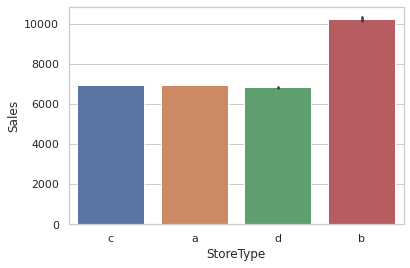

In [34]:
sns.set(style="whitegrid")
ax = sns.barplot(x="StoreType",y="Sales",data=train_store)

In [35]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


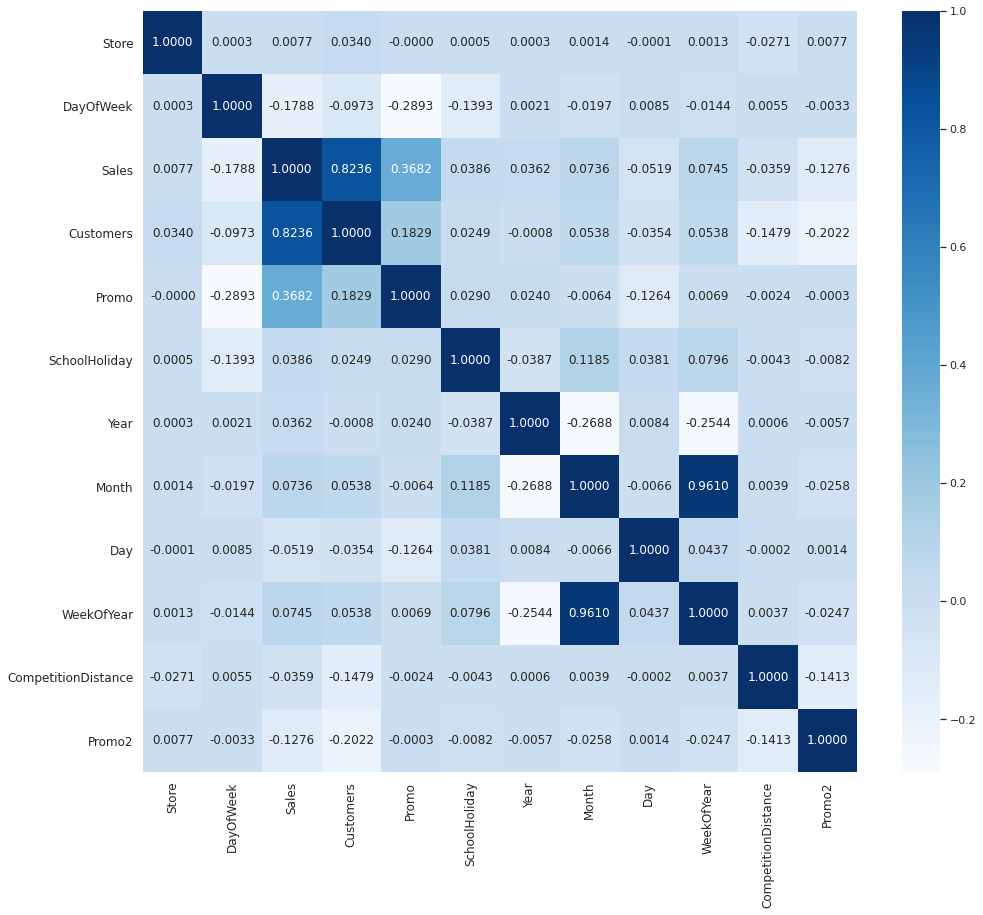

In [36]:
#correlation matrix
corrMatrix= train_store.drop('Open', axis = 1).corr()
f, ax = plt.subplots(figsize=(16, 14))
res=sns.heatmap(corrMatrix,cmap="Blues",annot=True,fmt='.4f',annot_kws={"size":12})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)
plt.show()

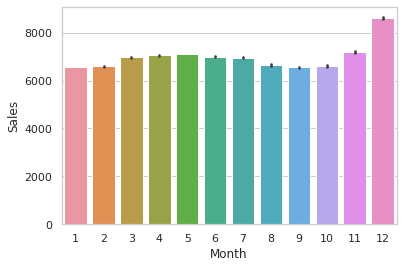

In [37]:
sns.set(style="whitegrid")

ax = sns.barplot(x="Month", y="Sales", data=train_store)

In [38]:
#check seasonality for the given store
def seasonality(store):
    sales = train_data[train_data.Store == store]
    sales = sales.sort_values(by = "Date",ascending= False)
    sns.set(rc = {'figure.figsize':(20,8)})
    sns.lineplot(x = sales["Date"], y = sales["Sales"], color= "green")
    plt.xticks(rotation=90)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Sales', fontsize=16)
    plt.title(f'Seasonality of store {store}\n', size=20, fontweight='bold')
    plt.show()

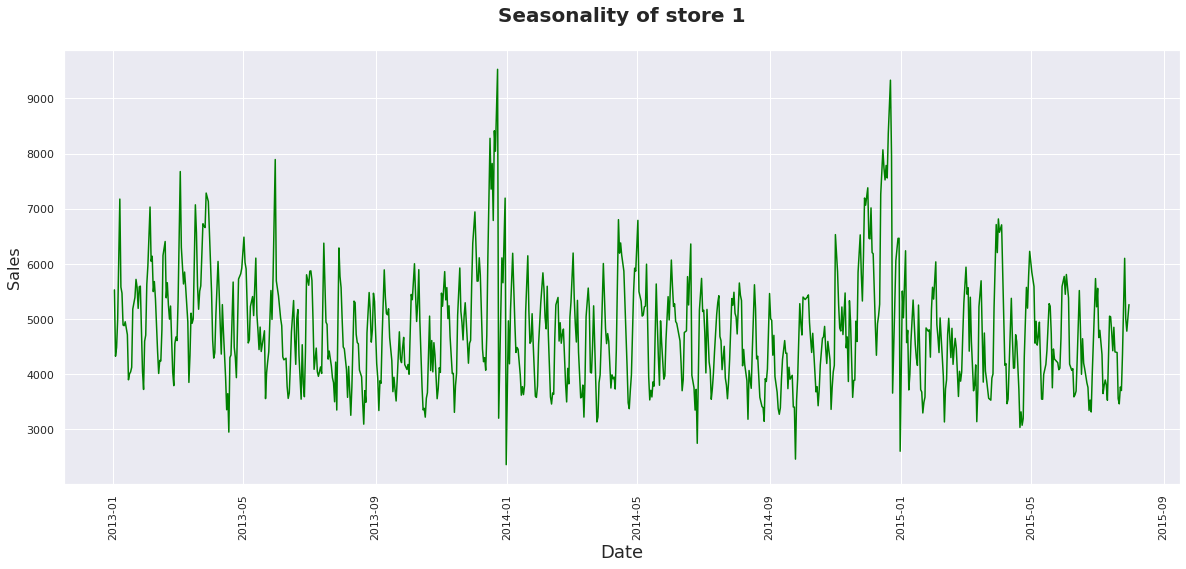

In [39]:
seasonality(1)

In [40]:
#check seasonality for 2013,2014 and 2015 for a given store
def seasonality_year(store):
    sale = train_data[train_data.Store == store]
    sale = sale[(sale.Year == 2015) | (sale.Year == 2014) | (sale.Year == 2013)]
    sale = sale.sort_values(by = "Date",ascending= False)
    sns.set(rc = {'figure.figsize':(20,8)})
    sns.lineplot(x = sale["Date"], y = sale["Sales"], color= "green")
    plt.xticks(rotation=90)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Sales', fontsize=16)
    plt.title(f'Seasonality of store {store} from 2013-2015 \n', size=20, fontweight='bold')
    plt.show()

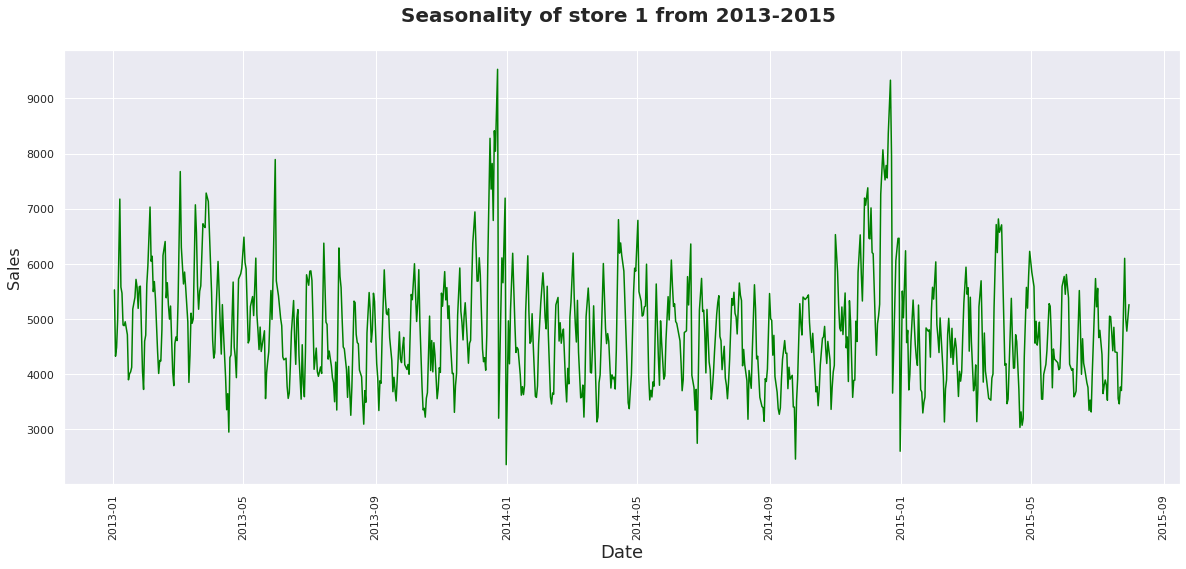

In [41]:
seasonality_year(1)

In [42]:
def plot_counts(df:pd.DataFrame, column1:str) -> None:
    plt.figure(figsize=(4, 2))
    sns.countplot(data=df, x=column1)
    plt.title(f'Distribution of {column1}\n', size=13, fontweight='bold')
    plt.show()

In [43]:
promo = pd.DataFrame()
promo['train promo'] = train_data['Promo']
promo['test promo'] = test_data['Promo']



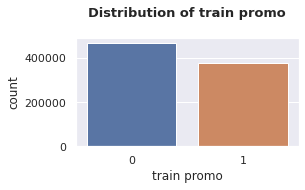

In [44]:

plot_counts(promo, 'train promo')


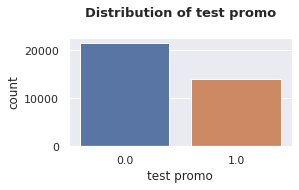

In [45]:

plot_counts(promo, 'test promo')

In [46]:
#sales behavior before, during and after holidays
pre_holiday = train_data[(train_data["Date"]> '2013-12-09') & (train_data["Date"]< '2013-12-22')  ]

during_holiday=train_data[(train_data["Date"]> '2013-12-22') & (train_data["Date"]< '2013-12-31')  ]

post_holiday = train_data[(train_data["Date"]> '2013-12-31') & (train_data["Date"]< '2014-01-15')  ]

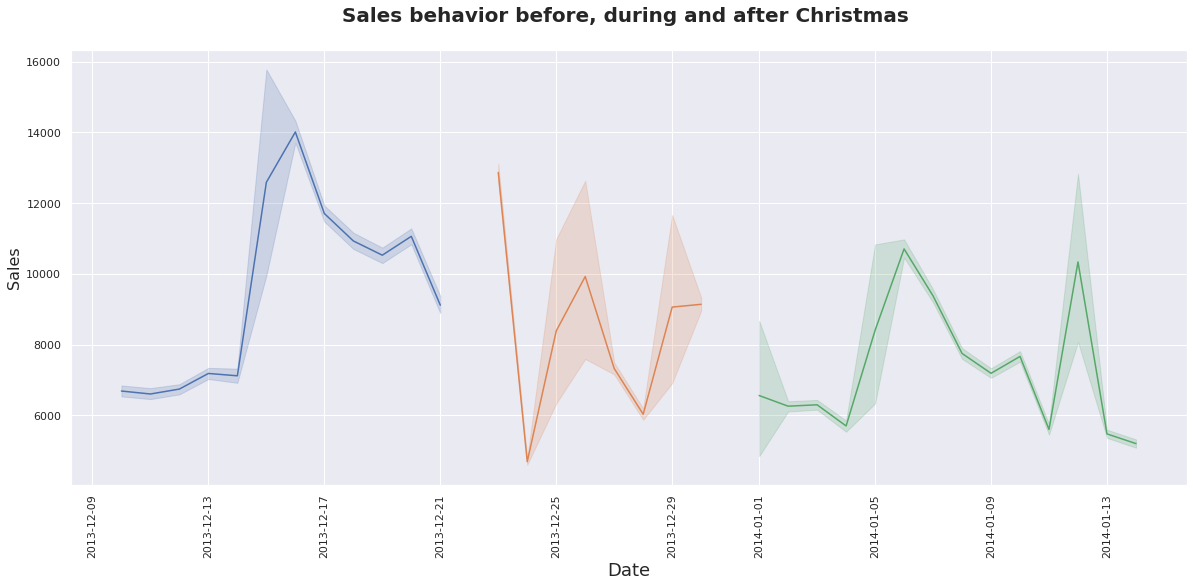

In [47]:
sns.lineplot(x = pre_holiday["Date"] , y = pre_holiday["Sales"] )
sns.lineplot(x = during_holiday["Date"] , y = during_holiday["Sales"] )
sns.lineplot(x = post_holiday["Date"] , y = post_holiday["Sales"] )
plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.title(f'Sales behavior before, during and after Christmas \n', size=20, fontweight='bold')
plt.show()

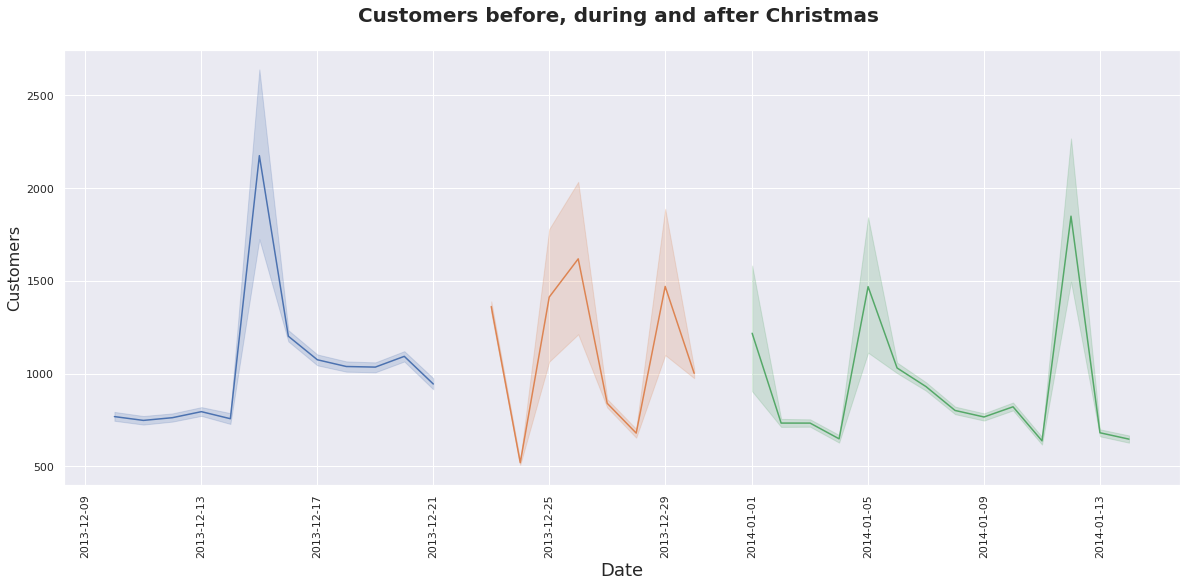

In [48]:

sns.lineplot(x = pre_holiday["Date"] , y = pre_holiday["Customers"] )
sns.lineplot(x = during_holiday["Date"] , y = during_holiday["Customers"] )
sns.lineplot(x = post_holiday["Date"] , y = post_holiday["Customers"] )
plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Customers', fontsize=16)
plt.title(f'Customers before, during and after Christmas \n', size=20, fontweight='bold')
plt.show()

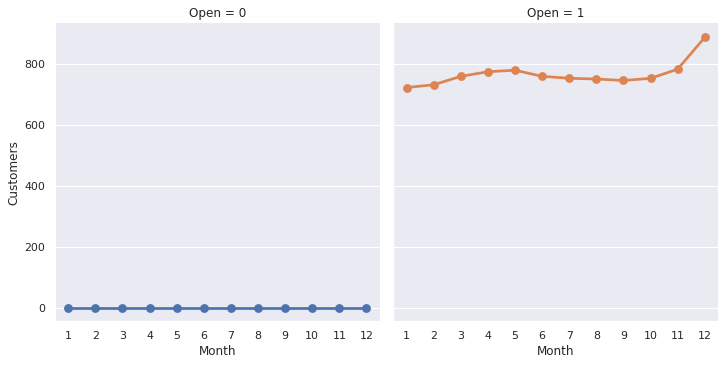

In [49]:
sns.factorplot(data = train_data_copy, x = 'Month', hue = 'Open',
               y = "Customers", 
               col = 'Open', # sales per promo  in cols
             
)  

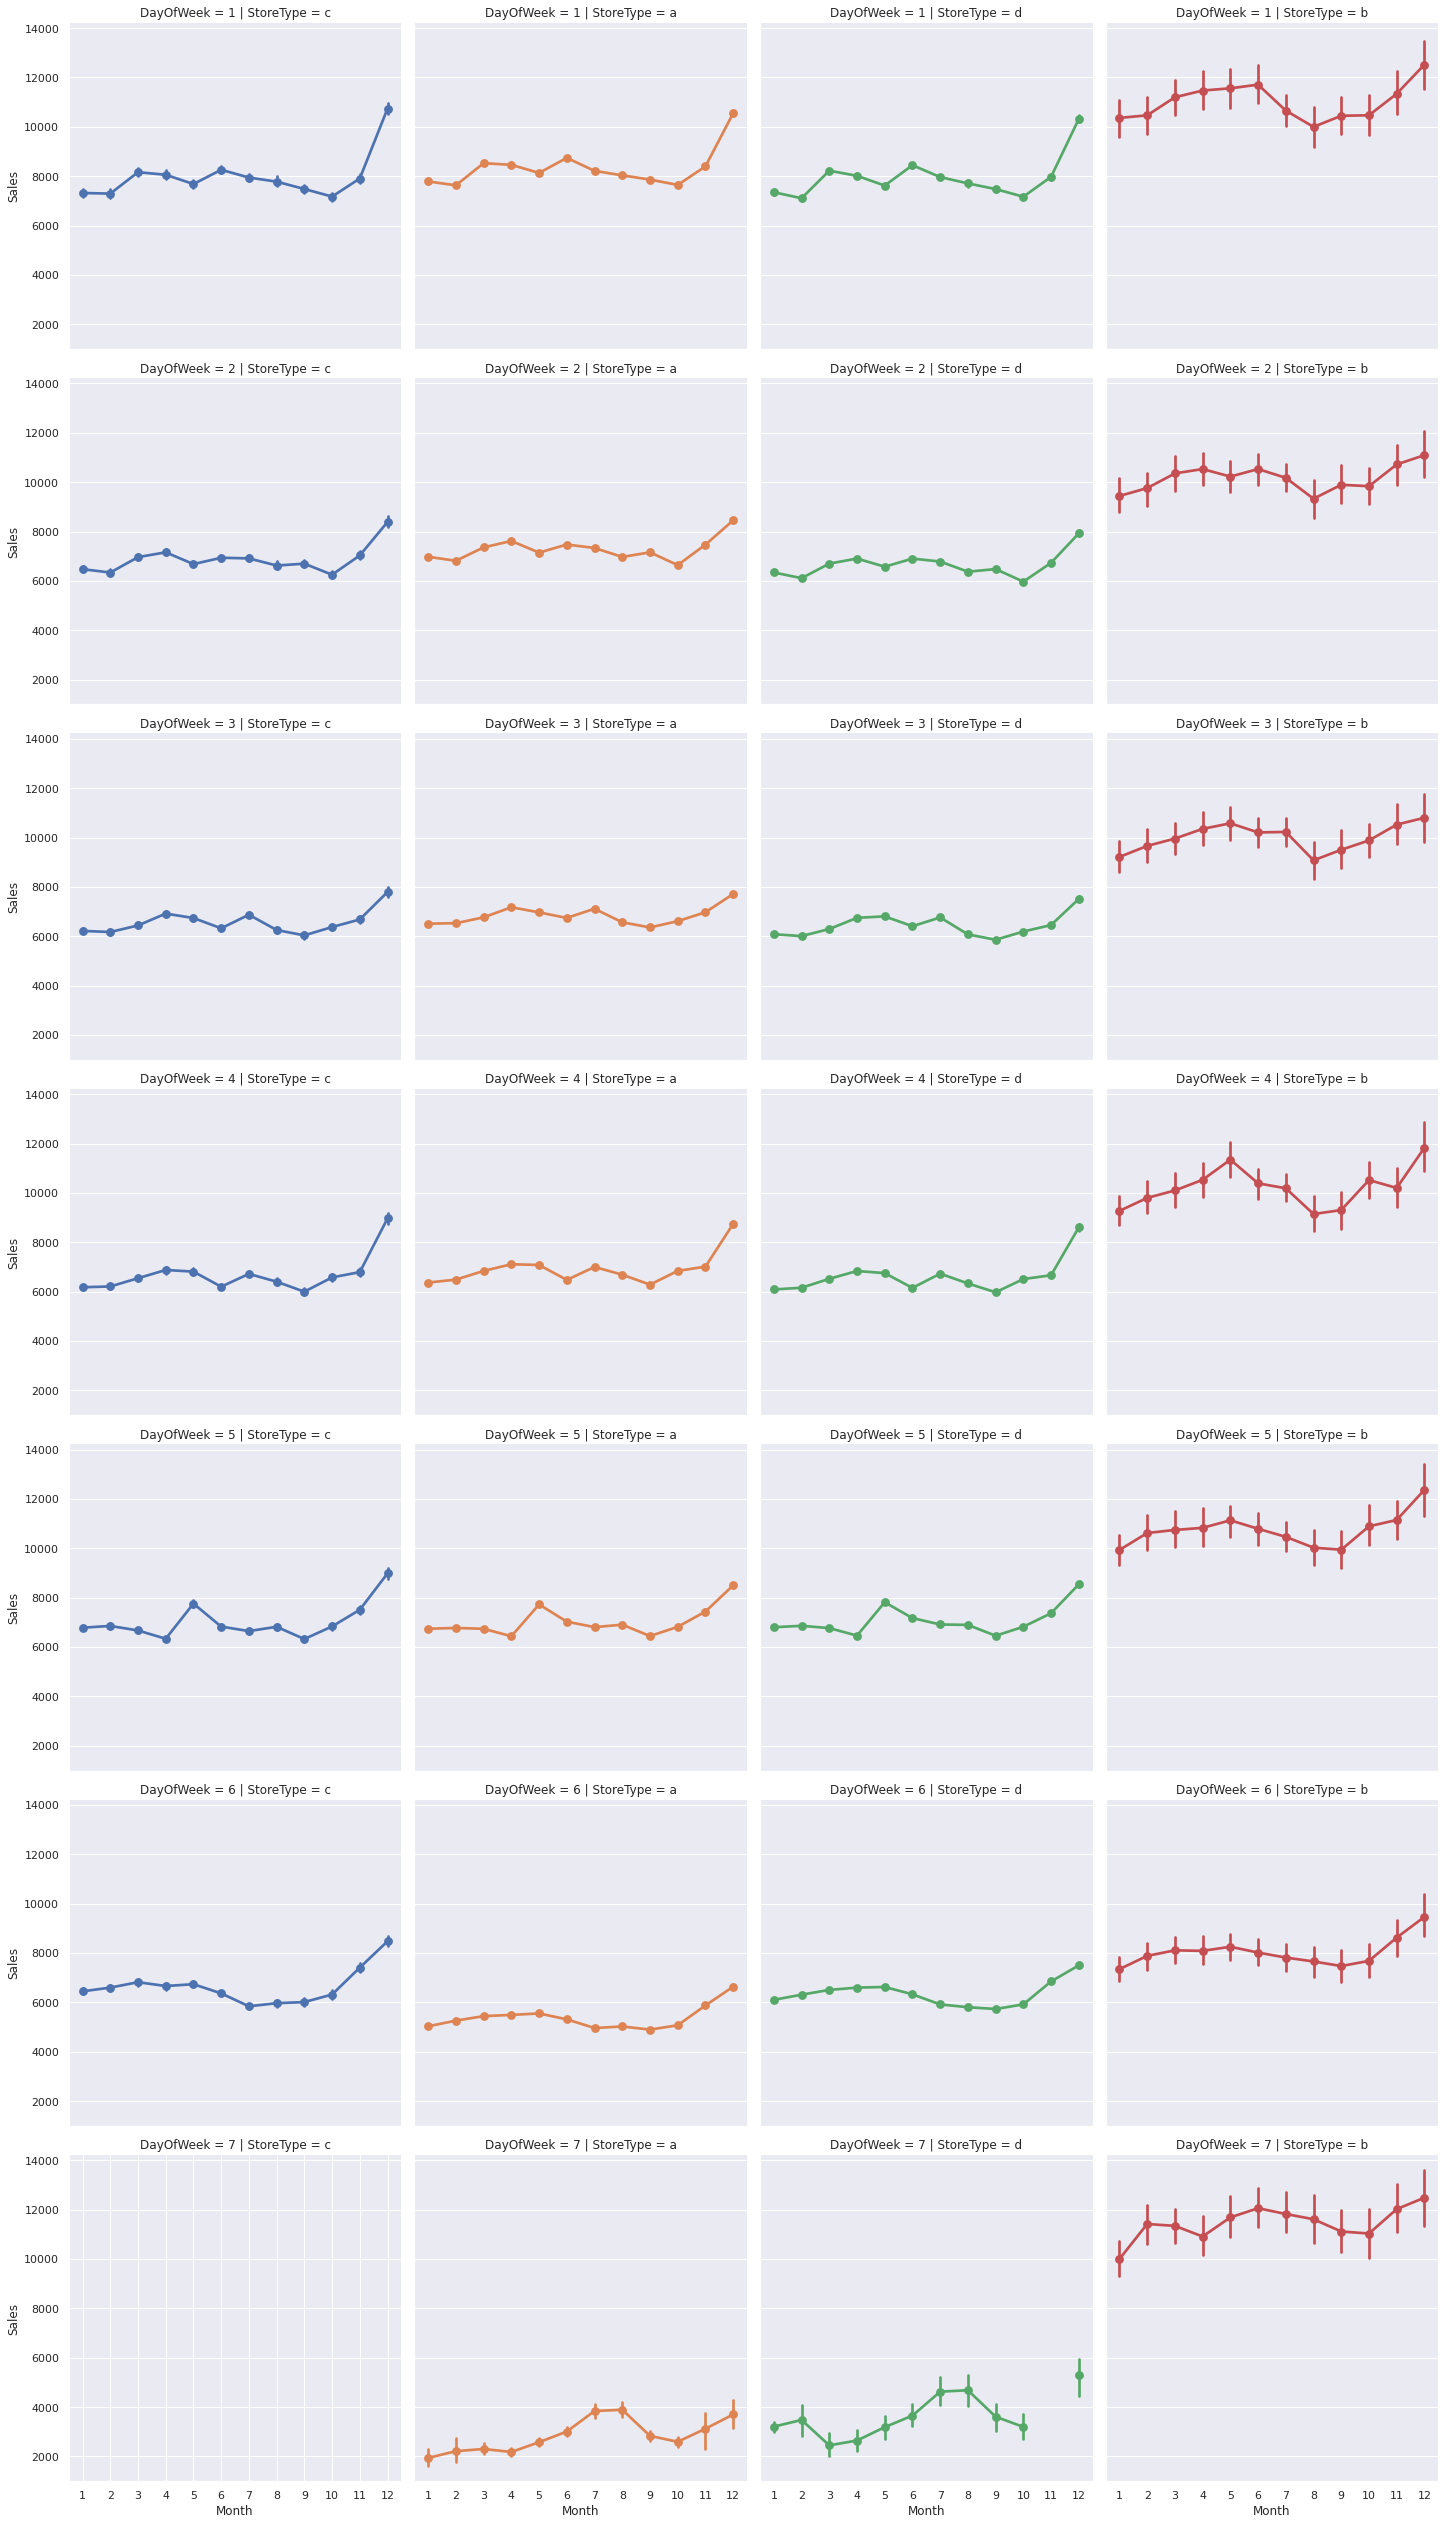

In [50]:
#customers trends
sns.factorplot(data = train_store, x = 'Month', y = "Sales", hue = 'StoreType',
               col = 'StoreType', # per store type in cols
               row = 'DayOfWeek', # per day of week in the stores
               ) 

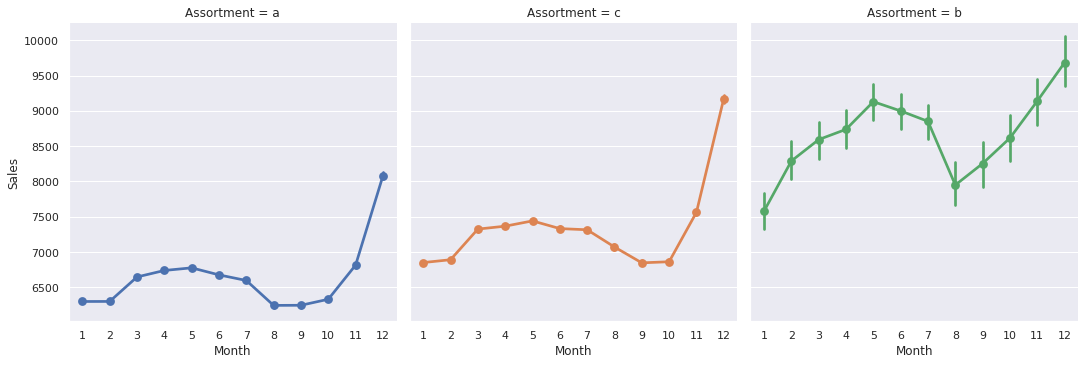

In [51]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales",hue = 'Assortment',
               col = 'Assortment') 

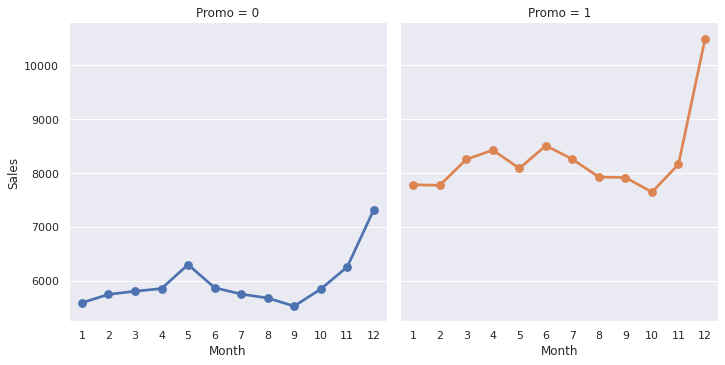

In [52]:
#promo and sales
sns.factorplot(data = train_store, x = 'Month', y = "Sales",hue = 'Promo',col = 'Promo') 

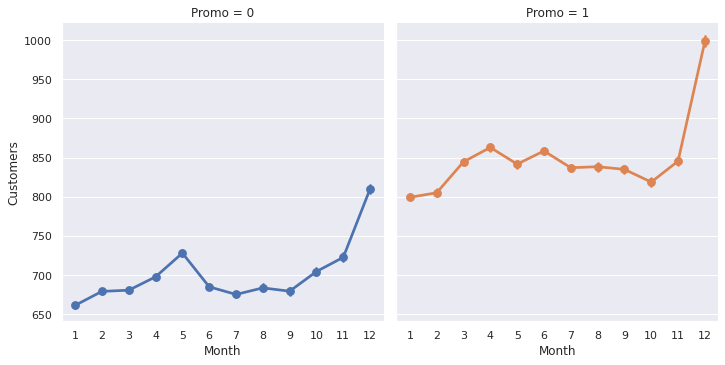

In [53]:
#promo and sales
sns.factorplot(data = train_store, x = 'Month', y = "Customers",hue = 'Promo',col = 'Promo')

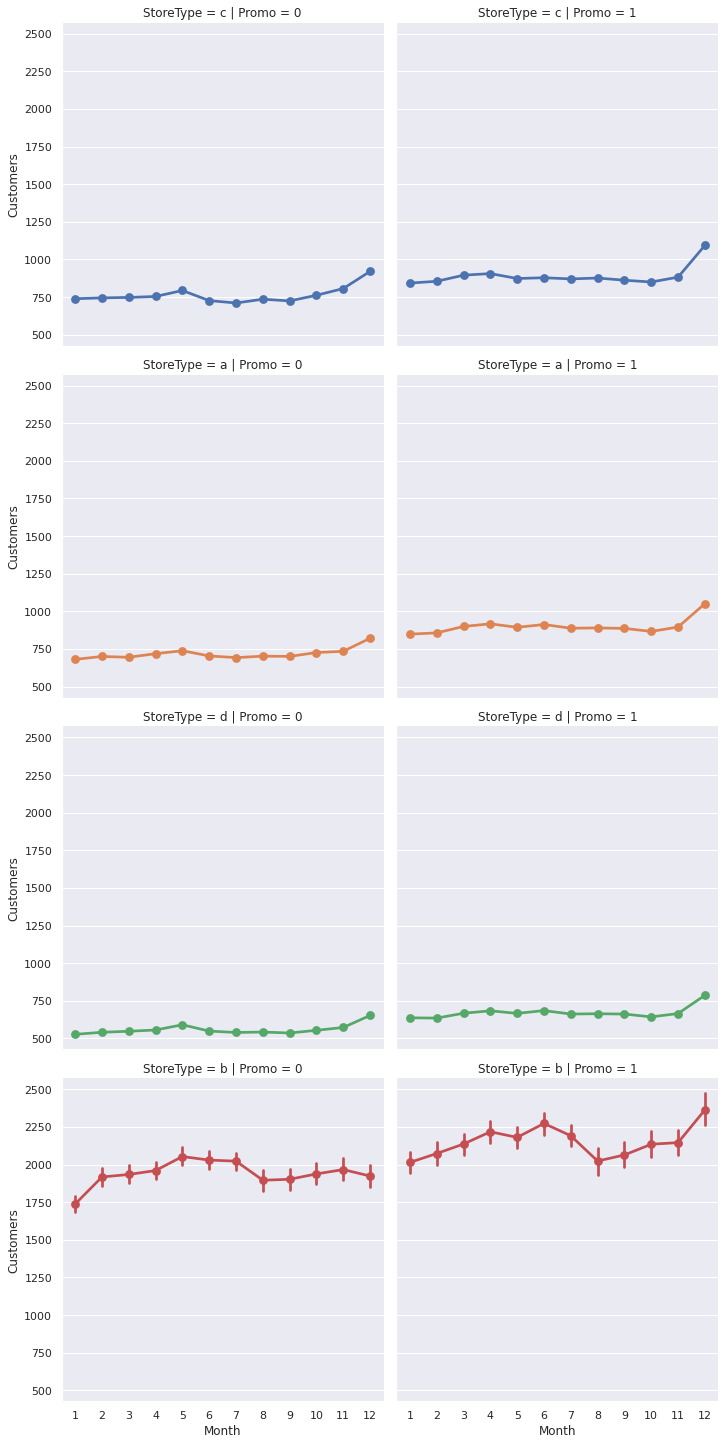

In [59]:
#Could the promos be deployed in more effective ways? Which stores should promos be deployed in?
#customers trends
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'Promo', # per store type in cols
               hue = 'StoreType',
               row = 'StoreType', # per promo in the store in rows
               ) 

In [54]:
comp_store = train_store.groupby("Store").agg({'CompetitionDistance':'max','Sales':'sum'})

<AxesSubplot:xlabel='CompetitionDistance', ylabel='Sales'>

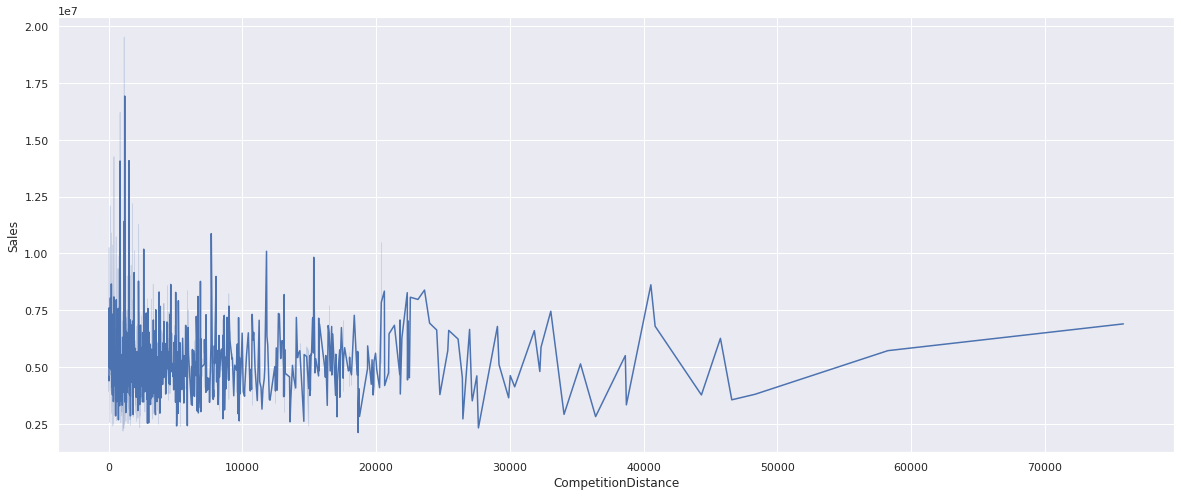

In [56]:
sns.lineplot(x = 'CompetitionDistance',y = "Sales",
             data = comp_store)